In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_labels = ["A", "T", "W", "X", "Y"]
full_data = {}
for char in data_labels:
    with open(f'{char}.pickle', 'rb') as f:
        data = np.load(f, allow_pickle=True)
        data["data"] = np.array(data["data"])
        full_data[char] = data
        print(f"data shape for {char} : {data['data'].shape}")

data shape for A : (76, 12, 2)
data shape for T : (74, 12, 2)
data shape for W : (76, 12, 2)
data shape for X : (81, 12, 2)
data shape for Y : (56, 12, 2)


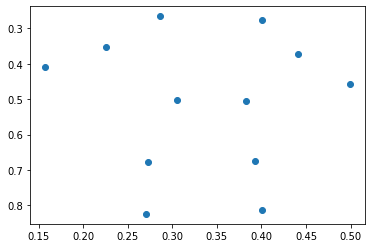

In [7]:
char  = "A"
idx = 12

x = full_data[char]['data'][idx][:, 0]
y = full_data[char]['data'][idx][:, 1]
scatter = plt.scatter(x, y)
ax = scatter.axes
ax.invert_yaxis()


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

In [46]:
X = []
y = []
keys = full_data.keys()
for label, key in enumerate(keys):
    data = full_data[key]["data"]
    for row in data:
        X.append(row)
        y.append(label)

X = np.array(X)
y = np.array(y)
y = to_categorical(y)

print(X.shape)
print(y.shape)

input_shape = X.shape
num_classes = y.shape[1]

(363, 12, 2)
(363, 5)


In [47]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=.2)

In [48]:
model = Sequential([
    Dense(20, input_shape=(12, 2), activation="relu"),
    Dense(14, activation="relu"),
    Flatten(),
    Dense(num_classes, activation="softmax"),

])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
    );

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 12, 20)            60        
_________________________________________________________________
dense_10 (Dense)             (None, 12, 14)            294       
_________________________________________________________________
flatten_2 (Flatten)          (None, 168)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 845       
Total params: 1,199
Trainable params: 1,199
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit(xtrain, ytrain, epochs=150, shuffle=True)

Epoch 1/150
10/10 [==============================] - 0s 1ms/step - loss: 1.6346 - accuracy: 0.1586
Epoch 2/150
10/10 [==============================] - 0s 1ms/step - loss: 1.6142 - accuracy: 0.2069
Epoch 3/150
10/10 [==============================] - 0s 1ms/step - loss: 1.6020 - accuracy: 0.2379
Epoch 4/150
10/10 [==============================] - 0s 2ms/step - loss: 1.5902 - accuracy: 0.2483
Epoch 5/150
10/10 [==============================] - 0s 1ms/step - loss: 1.5796 - accuracy: 0.2966
Epoch 6/150
10/10 [==============================] - 0s 2ms/step - loss: 1.5685 - accuracy: 0.2931
Epoch 7/150
10/10 [==============================] - 0s 2ms/step - loss: 1.5568 - accuracy: 0.2897
Epoch 8/150
10/10 [==============================] - 0s 2ms/step - loss: 1.5418 - accuracy: 0.3345
Epoch 9/150
10/10 [==============================] - 0s 1ms/step - loss: 1.5277 - accuracy: 0.3103
Epoch 10/150
10/10 [==============================] - 0s 2ms/step - loss: 1.5124 - accuracy: 0.2966
Epoch 11/

In [50]:
model.evaluate(xtest, ytest)

3/3 [==============================] - 0s 2ms/step - loss: 0.1132 - accuracy: 0.9726


[0.1132160872220993, 0.9726027250289917]

<AxesSubplot:>

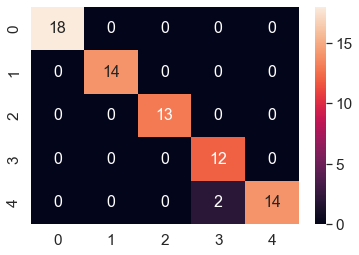

In [51]:
# from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sn


y_true = list(map(np.argmax, ytest))
y_pred = model.predict_classes(xtest)

cm = confusion_matrix(y_true, y_pred)
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size



In [52]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('classify_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpyalt239e/assets


INFO:tensorflow:Assets written to: /tmp/tmpyalt239e/assets
2021-12-10 01:04:44.115575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 01:04:44.116385: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2021-12-10 01:04:44.116484: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-12-10 01:04:44.116834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 01:04:44.117137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 960M computeCapability: 5.0
coreClock: 1.176GHz coreCount: 5 deviceMemorySize: 3.95Gi